# t-SNE visualization of Amazon reviews with polarity based color-coding 


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, visualize the data points through T-SNE for BoW, Bi-gram, TF-IDF, Avg-Word2Vec, TF-IDF-Word2Vec after classifying them into positive and negative.

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer


# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 



#getting the dataset into a dataframe 
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews where ProfileName like 'em%' and Score != 3
""", con) 
#filtering data to a limited set for fast computing

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['positiveNegative'] = positiveNegative # adding a new column 'positiveNegative' to the dataset


In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positiveNegative
0,793,B000UZMJZO,A1KG9W0FX5STMR,Emiliy Marino,1,2,4,1209254400,delicious,This tea is the best tea i've ever had. i firs...,positive
1,1318,B004EKO2HE,A7TCUZ9EVNRS0,emc,14,14,1,1315958400,Warning: Reviews do not reflect actual product...,"The current product, ""Certified Organic Raw Ca...",negative
2,1501,B002KGN4LE,A2UUIL3VICQQH0,Emily R.,1,1,5,1310256000,BUY ELSEWHERE,You can find this 6-pack for $40 dollars less ...,positive
3,1593,B001CWZXIY,A76CBKP9PQXJ3,Emily Gordon,0,0,5,1320624000,Both formulas are excellent for my dogs!,I have a nearly 1 year old golden retriever/st...,positive
4,2186,B002SW7ZOW,A25F57YK2GN6ST,Emme,3,6,2,1266537600,Tea is okay... teabag isn't.,"Just got my teabags today, and the first bag I...",negative


##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(842, 11)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

74.84444444444445

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['positiveNegative'].value_counts()

(842, 11)


positive    702
negative    140
Name: positiveNegative, dtype: int64

## Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [11]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
        i += 1;  

   

0
About the only thing wrong I can find with Wellness canned is the number of people who complain that their cats won't eat it -- even cats that were eating Wellness for awhile, suddenly they seem to lose interest.  People scramble to find why their cat suddenly won't eat it ("they've been eating Wellness for years!"), and end up blaming it on the company.<br /><br />It's not necessarily the company's fault. It's at least partially your fault for creating a routine in which you allowed your cat to become so finicky.<br /><br />As a human, there are a few brands I prefer simply because I grew up with them, and I know the taste of those brands blind-folded. I'm finicky about them.  Cats are *super*-sensitive and can taste even the smallest changes - including the plant their can of food was processed from!!!<br /><br />Don't let your cat become so finicky by feeding only one brand or flavor or variety consistently for years.  Mix it up.  Wellness may be the best, but there are several hi

In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))


{'we', "isn't", 'these', 'up', 'am', 'other', 'a', 'couldn', 'has', 'where', 'above', 'don', 'll', 'o', 'their', 'are', 'in', 'them', 'on', 'why', 'some', 'into', 'that', 'needn', 'they', 'he', 'further', 'there', 'during', 'themselves', 'down', 'than', 'be', 'wasn', "haven't", 'ourselves', 't', 's', 'when', 'about', 'under', 'hasn', 'from', 'do', "needn't", 'with', "shan't", 'whom', 'ma', 've', 'yourselves', 'had', 'too', 'him', 'his', 'hadn', 'will', 'was', 'i', 'the', 'while', 'your', 'any', 'most', 'as', "won't", 'or', 'you', 'who', "you'd", 'herself', 'aren', 'until', 'theirs', 'doing', 'if', 'her', 'hers', 'what', 'for', 'my', "hasn't", 'mightn', 'ain', "that'll", 'isn', 'each', 'being', 'did', "aren't", 'having', 'y', 'few', 'shouldn', 'this', 'himself', 'both', 'off', 'won', 'just', 'should', 'were', "didn't", 'same', 'once', "you've", 'm', 'again', 'only', 'own', 'but', 'shan', 'of', 'through', 'those', 'been', "couldn't", 'it', 'to', "mightn't", 'before', 'd', 'after', "shoul

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanhtml(cleanpunc(w)).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    #check whether the word is alphabatic or not+ length of the word is >2 or not
                if(cleaned_words.lower() not in stop): #checking whether the word belongs to stopword or not
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['positiveNegative'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['positiveNegative'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    #print(str1)
    #print("***********************************************************************")
    i+=1
#print(final_string)

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 

In [15]:
import csv
final.head(3) #below the processed review can be seen in the CleanedText Column 
final.to_csv('hmmm.csv')

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)


In [16]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,positiveNegative,CleanedText
951,479756,B00005U2FA,A18NG9I9MT2V8I,"Emm ""Emm""",0,0,4,1336867200,Works great!,This is the second one -- last one got lost in...,positive,b'second one last one got lost move found less...
281,142638,B000084E66,A3CA5M9D3CSK1Q,Emma's Mom,0,0,5,1301184000,Terrific cat food can cover,This is absolutely the best cat food can cover...,positive,b'absolut best cat food cover ever run across ...
179,86309,B000084E6V,A1UW1OD4G8752Q,"Emily D. Friedrichs ""Chintzy Shopaholic""",0,0,5,1325808000,Love this product!,I've always had good luck with Nylabone produc...,positive,b'ive alway good luck nylabon product dog abso...
178,86203,B000084E6V,A11JWHLCLSOQ40,Emilee,0,0,5,1218499200,Great!,I've had a Dental Dinosaur chew for about four...,positive,b'ive dental dinosaur chew four five year ever...
809,410194,B000084EZ4,A2YG3SRC8AMQ6G,Emily,3,4,5,1247356800,The best in the U.S. market today.,About the only thing wrong I can find with Wel...,positive,b'thing wrong find well can number peopl compl...


# Bag of Words (BoW)

In [17]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['Text'].values)
final_counts = final_counts.todense()

In [18]:
type(final_counts)

numpy.matrixlib.defmatrix.matrix

In [19]:
#final_counts.get_shape()

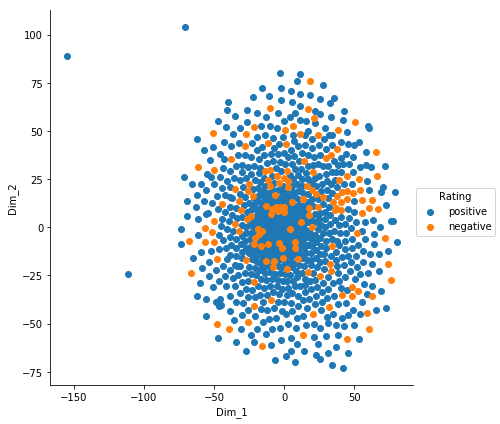

In [208]:

from sklearn.preprocessing import StandardScaler
import seaborn as sn

labels_1000 = final['positiveNegative']

# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=150.0,n_iter=1000,learning_rate=200,verbose=0,early_exaggeration=410)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_counts)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Rating"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


Observation: After trying various values for the parameters like perplexity,early_exaggeration etc, what we observed is that using BoW it is not possible to separate the positivae and negative data points.



















































































































































































































































































































































































































































































































































































































































































































































































































































































































































## Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [20]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print('****************************************************************')
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'tast', 394), (b'like', 369), (b'good', 290), (b'love', 278), (b'flavor', 249), (b'tea', 249), (b'great', 241), (b'use', 233), (b'tri', 231), (b'one', 222), (b'product', 209), (b'make', 199), (b'get', 174), (b'food', 168), (b'would', 163), (b'coffe', 156), (b'ive', 145), (b'realli', 144), (b'littl', 137), (b'find', 137)]
****************************************************************
Most Common Negative Words :  [(b'tast', 89), (b'like', 78), (b'flavor', 53), (b'product', 53), (b'order', 50), (b'one', 50), (b'would', 48), (b'tri', 47), (b'coffe', 40), (b'good', 35), (b'buy', 32), (b'use', 31), (b'get', 29), (b'item', 28), (b'even', 26), (b'dont', 26), (b'make', 26), (b'open', 25), (b'love', 24), (b'time', 24)]


<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [21]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['Text'].values)
final_bigram_counts = final_bigram_counts.todense()

In [22]:
#final_bigram_counts.get_shape()

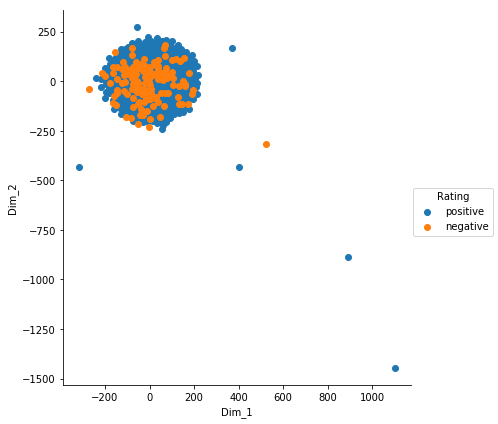

In [212]:

from sklearn.preprocessing import StandardScaler
import seaborn as sn

labels_1000 = final['positiveNegative']


# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=150.0,n_iter=1000,learning_rate=200,verbose=0,early_exaggeration=410)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_bigram_counts)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Rating"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


Observation: After trying various values for the parameters like perplexity,early_exaggeration etc, what we observed is that using Bi-gram it is not possible to separate the positivae and negative data points.

# TF-IDF

In [23]:

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['Text'].values)
print(final_tf_idf)


  (0, 37775)	0.0639662130109355
  (0, 18822)	0.06496075130762727
  (0, 35903)	0.025433776115981573
  (0, 31387)	0.10087755927841542
  (0, 25964)	0.10927063633605924
  (0, 20480)	0.08849463527002482
  (0, 15602)	0.08252764232709586
  (0, 21617)	0.1281418750854348
  (0, 18061)	0.03631445361157674
  (0, 23476)	0.14689049734349274
  (0, 1870)	0.05299020607090143
  (0, 41270)	0.06698974565496162
  (0, 14282)	0.07342199296487971
  (0, 35634)	0.04120229199882293
  (0, 20780)	0.15586244511551783
  (0, 5968)	0.09190561150639033
  (0, 30319)	0.12024953390831278
  (0, 40801)	0.044551199342163846
  (0, 3990)	0.08648165307632075
  (0, 24207)	0.14689049734349274
  (0, 10415)	0.08746526149091605
  (0, 31339)	0.1315528513218003
  (0, 38264)	0.15586244511551783
  (0, 37670)	0.08849463527002482
  (0, 16353)	0.1315528513218003
  :	:
  (841, 41037)	0.1281080771805124
  (841, 40082)	0.15647425238635926
  (841, 27498)	0.149683740986366
  (841, 41423)	0.17159506106250963
  (841, 23814)	0.1655657262590958
  (

In [24]:
final_tf_idf.get_shape()


(842, 43414)

In [25]:
features = tf_idf_vect.get_feature_names()
len(features)
#print(features)


43414

In [26]:
features[200:210]


['2009',
 '2009 and',
 '200mg',
 '200mg 300mg',
 '2010',
 '2010 the',
 '2011',
 '2011 and',
 '2011 was',
 '2012']

In [27]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 
final_tf_idf_f = final_tf_idf.todense()
#print(final_tf_idf_f)

[0. 0. 0. ... 0. 0. 0.]


In [28]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [29]:
top_tfidf


,feature,tfidf
0,run across,0.118758
1,first couple,0.118758
2,smaller cans,0.118758
3,can sizes,0.118758
4,were difficult,0.118758
5,become easier,0.118758
6,uses but,0.118758
7,common can,0.118758
8,cans they,0.118758
9,ever run,0.118758


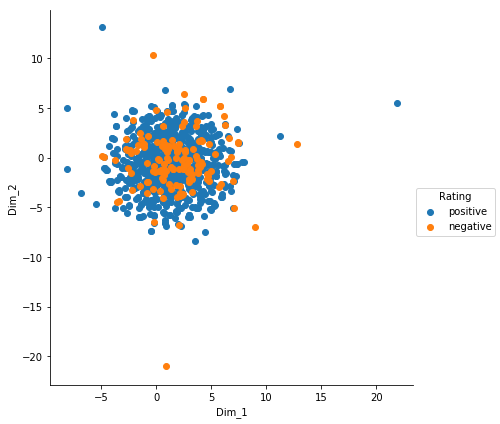

In [220]:
from sklearn.preprocessing import StandardScaler
import seaborn as sn

labels_1000 = final['positiveNegative']


# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=150.0,n_iter=1000,learning_rate=200,verbose=0,early_exaggeration=410)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(final_tf_idf_f)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Rating"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


Observation: After trying various values for the parameters like perplexity,early_exaggeration etc, what we observed is that using Tf-Idf it is not possible to separate the positivae and negative data points.

#  Word2Vec

In [30]:
# Using Google News Word2Vectors
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


model = KeyedVectors.load_word2vec_format('amazon-fine-food-reviews/GoogleNews-vectors-negative300.bin', binary=True)



In [31]:
model['computer']


array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [32]:
model.similarity('woman', 'man')

0.7664012230995352

In [33]:
model.most_similar('woman')

[('man', 0.7664012312889099),
 ('girl', 0.7494640946388245),
 ('teenage_girl', 0.7336829900741577),
 ('teenager', 0.631708562374115),
 ('lady', 0.6288785934448242),
 ('teenaged_girl', 0.6141784191131592),
 ('mother', 0.607630729675293),
 ('policewoman', 0.6069462299346924),
 ('boy', 0.5975908041000366),
 ('Woman', 0.5770983099937439)]

In [34]:
model.most_similar('tast')  # "tasti" is the stemmed word for tasty, tastful

[('Mmmmmm', 0.5823744535446167),
 ('Mmmmmmm', 0.5809869170188904),
 ('Bonnie_Benwick', 0.5797908306121826),
 ('mmm_mmm', 0.5761920213699341),
 ('sammich', 0.5737485289573669),
 ('jennajameson_@', 0.5694206357002258),
 ('Sniff_sniff', 0.5689424276351929),
 ('yo_momma', 0.567430853843689),
 ('greasy_fried', 0.567387580871582),
 ('@_WonderwallMSN', 0.5606350302696228)]

In [35]:
model.most_similar('tasty') 


[('delicious', 0.8730390071868896),
 ('scrumptious', 0.8007042407989502),
 ('yummy', 0.7856923937797546),
 ('flavorful', 0.7420163154602051),
 ('delectable', 0.7385421991348267),
 ('juicy_flavorful', 0.7114803791046143),
 ('appetizing', 0.7017217874526978),
 ('crunchy_salty', 0.7012301087379456),
 ('flavourful', 0.6912213563919067),
 ('flavoursome', 0.6857703328132629)]

In [36]:
model.similarity('tasty', 'tast')


0.440350541900889

In [40]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [41]:
print(final['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0:2])

This is the second one -- last one got lost in a move and we found that a lesser brand replacement was bad news (didn't seal tightly).  This thing is handy and does a great job.  Good price, too.
*****************************************************************
[['this', 'is', 'the', 'second', 'one', 'last', 'one', 'got', 'lost', 'in', 'a', 'move', 'and', 'we', 'found', 'that', 'a', 'lesser', 'brand', 'replacement', 'was', 'bad', 'news', 'didnt', 'seal', 'tightly', 'this', 'thing', 'is', 'handy', 'and', 'does', 'a', 'great', 'job', 'good', 'price', 'too'], ['this', 'is', 'absolutely', 'the', 'best', 'cat', 'food', 'can', 'cover', 'i', 'have', 'ever', 'run', 'across', 'it', 'fits', 'all', 'of', 'the', 'common', 'can', 'sizes', 'including', 'the', 'smaller', 'cans', 'they', 'seal', 'well', 'and', 'last', 'a', 'long', 'time', 'another', 'review', 'said', 'they', 'were', 'difficult', 'to', 'get', 'on', 'and', 'that', 'is', 'true', 'for', 'the', 'first', 'couple', 'of', 'uses', 'but', 'they

In [42]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
print(w2v_model)


Word2Vec(vocab=1489, size=50, alpha=0.025)


In [43]:
words = list(w2v_model.wv.vocab)
print(len(words))
print(words)

1489
['this', 'is', 'the', 'second', 'one', 'last', 'got', 'lost', 'in', 'a', 'and', 'we', 'found', 'that', 'brand', 'replacement', 'was', 'bad', 'didnt', 'seal', 'thing', 'handy', 'does', 'great', 'job', 'good', 'price', 'too', 'absolutely', 'best', 'cat', 'food', 'can', 'i', 'have', 'ever', 'run', 'across', 'it', 'all', 'of', 'common', 'including', 'smaller', 'cans', 'they', 'well', 'long', 'time', 'another', 'review', 'said', 'were', 'difficult', 'to', 'get', 'on', 'true', 'for', 'first', 'couple', 'uses', 'but', 'will', 'give', 'little', 'as', 'you', 'use', 'them', 'become', 'easier', 'snap', 'product', 'ive', 'always', 'had', 'with', 'products', 'my', 'dogs', 'love', 'though', 'think', 'away', 'from', 'shape', 'are', 'used', 'really', 'their', 'cant', 'beat', 'online', 'either', 'im', 'sure', 'would', 'be', 'twice', 'much', 'at', 'pet', 'store', 'dental', 'chew', 'about', 'four', 'or', 'five', 'years', 'every', 'dog', 'our', 'house', 'three', 'has', 'still', 'its', 'hard', 'which'

In [44]:
w2v_model.wv.most_similar('tasty')

[('eating', 0.9998265504837036),
 ('did', 0.9998151063919067),
 ('im', 0.9998027682304382),
 ('when', 0.9998023509979248),
 ('their', 0.9997968673706055),
 ('fat', 0.9997678399085999),
 ('theyre', 0.9997649788856506),
 ('an', 0.9997611045837402),
 ('small', 0.9997586011886597),
 ('cookies', 0.9997564554214478)]

In [45]:
w2v_model.wv.most_similar('like')

[('what', 0.9997262954711914),
 ('make', 0.9997185468673706),
 ('think', 0.9996972680091858),
 ('that', 0.9996955394744873),
 ('was', 0.9996933937072754),
 ('taste', 0.999691367149353),
 ('am', 0.9996864795684814),
 ('get', 0.9996811151504517),
 ('buying', 0.999677300453186),
 ('not', 0.9996769428253174)]

In [46]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
#print(count_vect_feat)
count_vect_feat.index('00')

print(count_vect_feat[0])

00


#  Avg W2V, TFIDF-W2V

In [47]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
#print(sent_vectors[0])

842
50


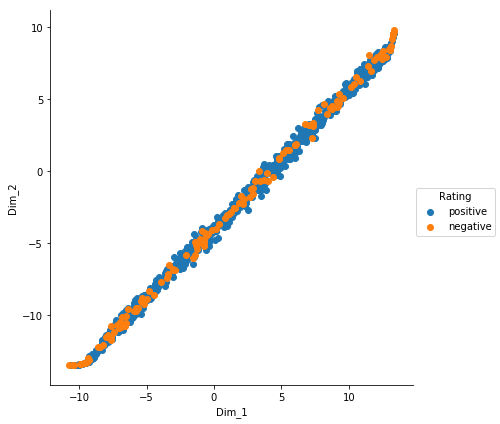

In [48]:
from sklearn.preprocessing import StandardScaler
import seaborn as sn

labels_1000 = final['positiveNegative']

# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=150.0,n_iter=1000,learning_rate=200,verbose=0,early_exaggeration=350)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Rating"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


Observation: After trying various values for the parameters like perplexity,early_exaggeration etc, what we observed is that using Avg-Word2Vec it is not possible to separate the positivae and negative data points.

In [49]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1


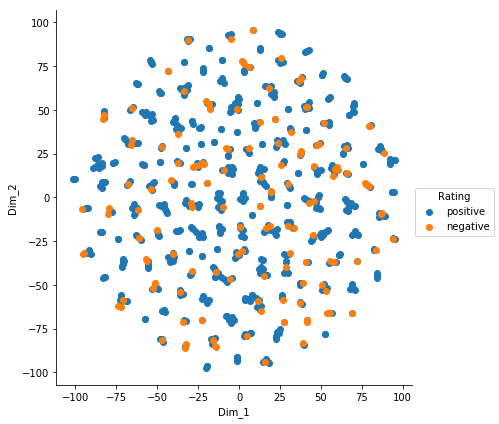

In [50]:
from sklearn.preprocessing import StandardScaler
import seaborn as sn

labels_1000 = final['positiveNegative']


# TSNE

from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0,perplexity=0.5,n_iter=1000,learning_rate=200,verbose=0,early_exaggeration=12)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(tfidf_sent_vectors)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_1000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "Rating"))

# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="Rating", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

Observation: After trying various values for the parameters like perplexity,early_exaggeration etc, what we observed is that using Tf-Idf-Word2Vec it is not possible to separate the positivae and negative data points.